### Libraries

In [1]:
## Standard libraries
import os
import pandas as pd
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision import transforms, datasets

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/scratch/users/nus/e1329380/models/SimCLR" ###
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = 16 ### os.cpu_count()

# Setting the seed
pl.seed_everything(2024)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

/var/tmp/pbs.6561492.pbs101/ipykernel_1203015/2384079658.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
/home/users/nus/e1329380/conda/cs5246/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 2024


Device: cuda:0
Number of workers: 16


<Figure size 640x480 with 0 Axes>

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: eying001. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb_logger = WandbLogger(project='Learning Representations from Retail Images', log_model="all", job_type='train')
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_acc_top5", mode="max")

In [2]:
# print("Loading data...")
# train_paths = []
# TRAIN_PATH = "/scratch/users/nus/e1329380/data/all/train/others"
# for x in os.listdir(TRAIN_PATH):
#     train_paths.append(f"{TRAIN_PATH}/{x}")
# train_data = pd.DataFrame()
# train_data['ImagePath'] = train_paths
# for i in range(10):
#     train_data = train_data.sample(frac=1).reset_index(drop=True)
# len(train_paths)

Loading data...


9586

In [3]:
# print("Loading data...")
# test_paths = []
# TEST_PATH = "/scratch/users/nus/e1329380/data/all/test/others"
# for x in os.listdir(TEST_PATH):
#     test_paths.append(f"{TEST_PATH}/{x}")
# test_data = pd.DataFrame()
# test_data['ImagePath'] = test_paths
# for i in range(10):
#     test_data = test_data.sample(frac=1).reset_index(drop=True)

# len(test_paths)

Loading data...


1069

Most of the code inspiration is from: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html

### Data Augmentation for Contrastive Learning

In [4]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [5]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=224), ###
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ###
                                         ])

### Data
Investigate "others" class

In [ ]:
# shifted others into others_folder

In [6]:
# # shift items with less than 10 images into others_folder
# for x in os.listdir("/scratch/users/nus/e1329380/data/all/train"):
#     if len(os.listdir(f"/scratch/users/nus/e1329380/data/all/train/{x}"))<10:
#         os.rename(f"/scratch/users/nus/e1329380/data/all/train/{x}", f"/scratch/users/nus/e1329380/data/all/train/others_folder/{x}")

In [10]:
# # move items with zero images back
# for x in os.listdir("/scratch/users/nus/e1329380/data/all/train/others_folder"):
#     if len(os.listdir(f"/scratch/users/nus/e1329380/data/all/train/others_folder/{x}")) == 0:
#         os.rename(f"/scratch/users/nus/e1329380/data/all/train/others_folder/{x}", f"/scratch/users/nus/e1329380/data/all/train/{x}")

In [6]:
TRAIN_PATH = "/scratch/users/nus/e1329380/data/all/train/others_folder"
unlabeled_data = datasets.ImageFolder(TRAIN_PATH, transform = ContrastiveTransformations(contrast_transforms, n_views=2))

In [8]:
len(unlabeled_data)

13343

In [9]:
unlabeled_data[0][0][0].shape

torch.Size([3, 224, 224])

In [10]:
unlabeled_data[0][0][1].shape

torch.Size([3, 224, 224])

Seed set to 2024


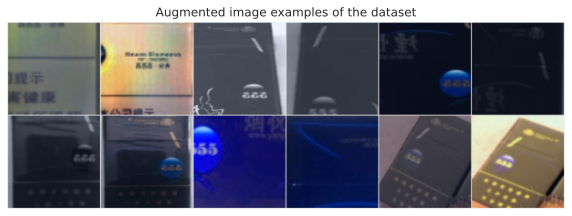

In [11]:
# Visualize some examples
pl.seed_everything(2024)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Model

In [2]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=20):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet50(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

### Trainer

In [13]:
pl.seed_everything(2024)
train_set, val_set = torch.utils.data.random_split(unlabeled_data, [0.8, 0.2])

Seed set to 2024


In [14]:
len(train_set), len(val_set)

(10675, 2668)

In [16]:
def train_simclr(batch_size, max_epochs=200, **kwargs):
    trainer = pl.Trainer(default_root_dir=CHECKPOINT_PATH,
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[#early_stop_callback,
                                    ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')],
                         logger=wandb_logger,)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt') ###
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(2024) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

### Training

In [ ]:
simclr_model = train_simclr(batch_size=128,
                            hidden_dim=128, # embedding size
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=200) ###

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 2024
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-5b8cfe65-7543-b509-3879-c4b2c0c15baf]

  | Name    | Type   | Params
-----------------------------------
0 | convnet | ResNet | 24.6 M
-----------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.491    Total estimated model params size (MB)


Epoch 0: 100%|████████████████████████████████████████████████████████████████| 83/83 [00:32<00:00,  2.55it/s, v_num=i2js]
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████| 83/83 [00:27<00:00,  3.06it/s, v_num=i2js]
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████| 83/83 [00:27<00:00,  3.06it/s, v_num=i2js]
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████████████████████████████████████████████████████████████████| 83/83 [00:27<00:00,  3.04it/s, v_num=i2js]
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██

In [18]:
simclr_model

SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

### Test

In [3]:
# from distutils.dir_util import copy_tree
# import shutil
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pickle
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
# from PIL import Image
# from matplotlib import font_manager
# fontP = font_manager.FontProperties()
# fontP.set_family('Heiti TC')

In [180]:
# font_manager.findfont('SimHei')

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


'/home/users/nus/e1329380/conda/cs5246/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [ ]:
# shutil.copytree("/scratch/users/nus/e1329380/data/all/test/施华蔻羊绒脂滋养洗发露600", "/home/users/nus/e1329380/cs5242/project/images_test/施华蔻羊绒脂滋养洗发露600")

In [11]:
# copy_tree("/scratch/users/nus/e1329380/data/all/test/东古金标蚝油", "/home/users/nus/e1329380/cs5242/project/images_test/东古金标蚝油")

['/home/users/nus/e1329380/cs5242/project/images_test/泸州老窖52度D9精品头曲500ml/企业微信截图_a75fc053-9e23-45ca-9e98-97e0c0c32fb2.png',
 '/home/users/nus/e1329380/cs5242/project/images_test/泸州老窖52度D9精品头曲500ml/0518_596_0.8683915.jpg']

In [50]:
# retreive trained model
model = SimCLR.load_from_checkpoint("/home/users/nus/e1329380/cs5242/project/Learning Representations from Retail Images/951ii2js/checkpoints/epoch=189-step=15770.ckpt")
model = model.convnet
model.fc = nn.Identity()  # Removing projection head g(.)
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Try clustering train items images (trained on)

In [110]:
os.mkdir("/scratch/users/nus/e1329380/data/all/train/temp")
interested = []
for x in os.listdir("/scratch/users/nus/e1329380/data/all/test"):
    if len(os.listdir(f"/scratch/users/nus/e1329380/data/all/test/{x}"))==2:
        if len(interested) == 7:
            break
        print(x)
        print(len(os.listdir(f"/scratch/users/nus/e1329380/data/all/train/others_folder/{x}")))
        interested.append(x)
        os.rename(f"/scratch/users/nus/e1329380/data/all/train/others_folder/{x}", f"/scratch/users/nus/e1329380/data/all/train/temp/{x}")

钻石（金玉兰）
9
白猫生姜洗洁精1.7kg
9
泸州老窖52度D9精品头曲500ml
9
海飞丝黑亮强韧型去屑洗发露400
9
古井贡酒G3年份原浆500ml
9
竹叶青酒500ml
9
伊利优酸乳草莓味250ml
9


In [111]:
DATA_PATH = "/scratch/users/nus/e1329380/data/all/train/temp/"
# ignore this: transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
unlabeled_data = datasets.ImageFolder(DATA_PATH, transform = transforms.Compose([transforms.CenterCrop(size=224), transforms.ToTensor()]))
# some how got duplicated images (whyyyyy?)
val_loader = data.DataLoader(unlabeled_data, batch_size=128, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
for batch_imgs, batch_labels in val_loader:
    batch_feats = model(batch_imgs.to(device))

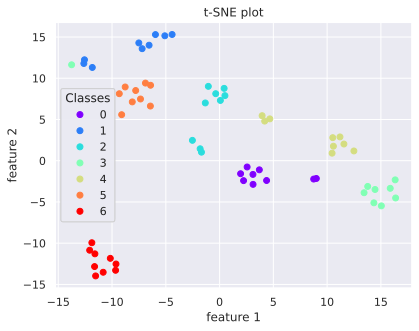

In [112]:
tsne = TSNE(n_components = 2, init = 'pca', random_state = 2024, perplexity = 9)

X_reduced = tsne.fit_transform(batch_feats.cpu().detach().numpy())

fig, ax = plt.subplots()

scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c = batch_labels.cpu().detach().numpy(), cmap = "rainbow")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('t-SNE plot')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

In [114]:
# put back
for x in interested:
    os.rename(f"/scratch/users/nus/e1329380/data/all/train/temp/{x}", f"/scratch/users/nus/e1329380/data/all/train/others_folder/{x}")

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/nus/e1329380/data/all/train/temp/钻石（金玉兰）' -> '/scratch/users/nus/e1329380/data/all/train/others_folder/钻石（金玉兰）'

In [116]:
os.rmdir("/scratch/users/nus/e1329380/data/all/train/temp/")

#### Try clustering test items images (trained on)

In [52]:
# testing on test images on items less than 10 in train
DATA_PATH = "/home/users/nus/e1329380/cs5242/project/images_test/"
# ignore this: transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
unlabeled_data = datasets.ImageFolder(DATA_PATH, transform = transforms.Compose([transforms.CenterCrop(size=224), transforms.ToTensor()]))
# some how got duplicated images (whyyyyy?)
val_loader = data.DataLoader(unlabeled_data, batch_size=64, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
for batch_imgs, batch_labels in val_loader:
    batch_feats = model(batch_imgs.to(device))
cos_sim = F.cosine_similarity(batch_feats[:,None,:], batch_feats[None,:,:], dim=-1)
self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
cos_sim = cos_sim.masked_fill_(self_mask, -9e15)

In [53]:
dists = euclidean_distances(batch_feats.to("cpu").detach().numpy(), batch_feats.to("cpu").detach().numpy()) + np.eye(len(batch_feats))*100

In [54]:
# euclidean distance
np.argmin(dists, axis = -1)

array([ 1,  0,  3,  2,  5,  4,  7,  6,  9,  8, 11, 10])

In [146]:
# cosine similarity
torch.argmax(cos_sim, dim = -1)

tensor([ 1,  0,  3,  2,  5,  4,  7,  6,  9,  8, 11, 10], device='cuda:0')

In [185]:
# unlabeled_data.imgs

In [9]:
list(set([x[0].split("/")[-2] for x in unlabeled_data.imgs]))

['海飞丝黑亮强韧型去屑洗发露400',
 '伊利优酸乳草莓味250ml',
 '竹叶青酒500ml',
 '红星二锅头65度500ml',
 '白猫生姜洗洁精1.7kg',
 '古井贡酒G3年份原浆500ml']

/home/users/nus/e1329380/conda/cs5246/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/users/nus/e1329380/conda/cs5246/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39134 (\N{CJK UNIFIED IDEOGRAPH-98DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/users/nus/e1329380/conda/cs5246/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19997 (\N{CJK UNIFIED IDEOGRAPH-4E1D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/users/nus/e1329380/conda/cs5246/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 40657 (\N{CJK UNIFIED IDEOGRAPH-9ED1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/users/nus/e1329380/conda/cs5246/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: Us

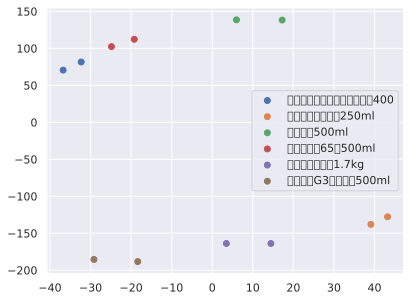

In [10]:
tsne = TSNE(n_components = 2, init = 'random', random_state = 2024, perplexity = 2)

X_reduced = tsne.fit_transform(batch_feats.cpu().detach().numpy())

fig, ax = plt.subplots()

count = 0
for i in range(6):
    plt.scatter(X_reduced[count: count + 2, 0], X_reduced[count: count + 2, 1])
    count += 2

plt.legend(list(set([x[0].split("/")[-2] for x in unlabeled_data.imgs])))
plt.show()

# scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], label=[x[0].split("/")[-2] for x in unlabeled_data.imgs], c = batch_labels.cpu().detach().numpy(), cmap = "rainbow")

# # produce a legend with the unique colors from the scatter
# ax.legend()
# # legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
# # ax.add_artist(legend1)
# plt.title('t-SNE plot')
# plt.xlabel('feature 1')
# plt.ylabel('feature 2')
# plt.show()

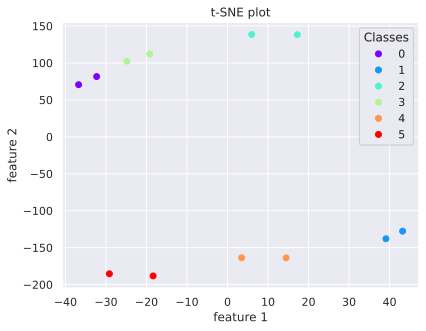

In [11]:
tsne = TSNE(n_components = 2, init = 'random', random_state = 2024, perplexity = 2)

X_reduced = tsne.fit_transform(batch_feats.cpu().detach().numpy())

fig, ax = plt.subplots()

scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c = batch_labels.cpu().detach().numpy(), cmap = "rainbow")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('t-SNE plot')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

#### Analyse items in others

In [6]:
# testing on test images in others
with torch.no_grad():
    DATA_PATH = "/scratch/users/nus/e1329380/data/all/test/others_folder"
    # ignore this: transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    unlabeled_data = datasets.ImageFolder(DATA_PATH, transform = transforms.Compose([transforms.CenterCrop(size=224), transforms.ToTensor()]))
    print(len(unlabeled_data), len(os.listdir("/scratch/users/nus/e1329380/data/all/test/others_folder/others")))
    val_loader = data.DataLoader(unlabeled_data, batch_size=2048, shuffle=False,
                                         drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
    for batch_imgs, batch_labels in val_loader:
        temp = batch_imgs.to(device)
        batch_feats = model(temp)
        temp.to("cpu")

1069 1069


In [66]:
with open("/home/users/nus/e1329380/cs5242/project/embeddings/test_others_embeddings.p", 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(batch_feats.to("cpu").detach().numpy(), f, pickle.HIGHEST_PROTOCOL)

In [67]:
with open("/home/users/nus/e1329380/cs5242/project/embeddings/test_others_path.p", 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(unlabeled_data.imgs, f, pickle.HIGHEST_PROTOCOL)

In [7]:
cos_sim = F.cosine_similarity(batch_feats[:,None,:], batch_feats[None,:,:], dim=-1)
self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
cos_sim = cos_sim.masked_fill_(self_mask, -9e15)

In [9]:
torch.argmax(cos_sim, dim = -1)

tensor([855, 798, 904,  ..., 935, 405, 488], device='cuda:0')

In [8]:
[(i, x.item()) for i, x in enumerate(torch.argmax(cos_sim, dim = -1)) if cos_sim[i, x]>=0.98]

[(0, 855),
 (2, 904),
 (4, 94),
 (5, 905),
 (7, 904),
 (8, 843),
 (9, 1018),
 (10, 49),
 (12, 852),
 (13, 902),
 (14, 21),
 (15, 819),
 (16, 854),
 (18, 826),
 (19, 829),
 (21, 14),
 (27, 835),
 (28, 779),
 (29, 45),
 (30, 1053),
 (31, 903),
 (32, 35),
 (33, 1015),
 (34, 1053),
 (35, 58),
 (39, 40),
 (40, 39),
 (41, 830),
 (42, 858),
 (43, 406),
 (44, 893),
 (45, 883),
 (46, 826),
 (49, 10),
 (53, 860),
 (54, 912),
 (57, 838),
 (58, 877),
 (59, 830),
 (60, 836),
 (61, 903),
 (62, 1054),
 (75, 815),
 (82, 93),
 (84, 1052),
 (85, 793),
 (86, 147),
 (90, 100),
 (93, 82),
 (94, 1017),
 (95, 1016),
 (98, 887),
 (100, 1016),
 (101, 887),
 (102, 103),
 (103, 102),
 (108, 863),
 (111, 405),
 (112, 848),
 (113, 803),
 (114, 207),
 (115, 114),
 (116, 18),
 (121, 920),
 (122, 356),
 (124, 207),
 (132, 336),
 (133, 238),
 (138, 139),
 (139, 138),
 (146, 768),
 (147, 155),
 (150, 158),
 (154, 156),
 (155, 156),
 (156, 154),
 (157, 158),
 (158, 157),
 (166, 418),
 (168, 169),
 (169, 168),
 (170, 174

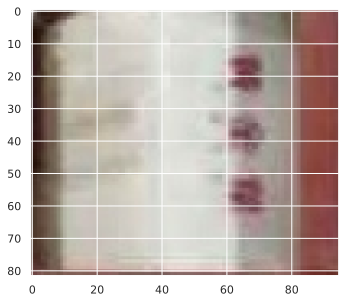

In [22]:
IMG_PATH = unlabeled_data.imgs[0][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0))

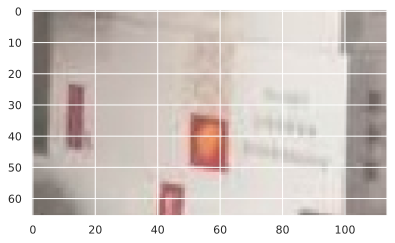

In [12]:
IMG_PATH = unlabeled_data.imgs[855][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

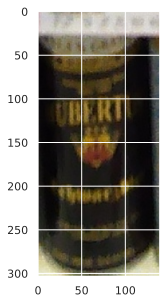

In [13]:
IMG_PATH = unlabeled_data.imgs[690][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

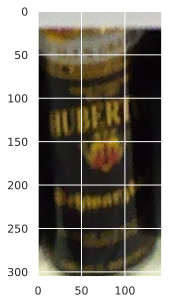

In [14]:
IMG_PATH = unlabeled_data.imgs[694][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

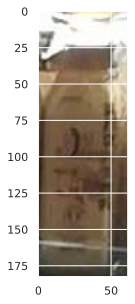

In [14]:
IMG_PATH = unlabeled_data.imgs[1036][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

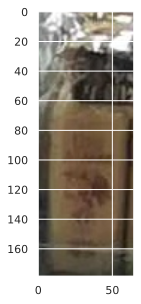

In [15]:
IMG_PATH = unlabeled_data.imgs[1037][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

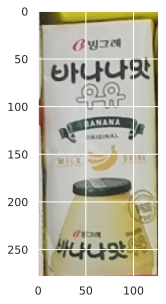

In [13]:
IMG_PATH = unlabeled_data.imgs[683][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

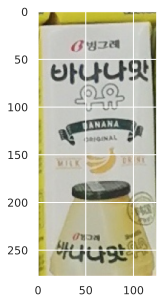

In [16]:
IMG_PATH = unlabeled_data.imgs[681][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

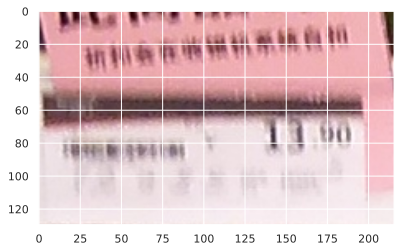

In [17]:
IMG_PATH = unlabeled_data.imgs[704][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

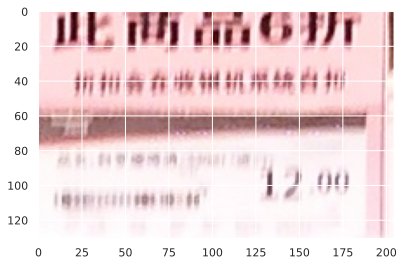

In [18]:
IMG_PATH = unlabeled_data.imgs[703][0]
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

#### Try clustering test items images(not trained on)

In [154]:
os.mkdir("/scratch/users/nus/e1329380/data/all/test/temp")
interested = []
for x in os.listdir("/scratch/users/nus/e1329380/data/all/test"):
    if x not in os.listdir("/scratch/users/nus/e1329380/data/all/train/others_folder"):
        if len(os.listdir(f"/scratch/users/nus/e1329380/data/all/test/{x}"))>5 and len(os.listdir(f"/scratch/users/nus/e1329380/data/all/test/{x}"))<13:
            if len(interested) == 5:
                break
            print(len(os.listdir(f"/scratch/users/nus/e1329380/data/all/test/{x}")))
            print(x)
            interested.append(x)
            os.rename(f"/scratch/users/nus/e1329380/data/all/test/{x}", f"/scratch/users/nus/e1329380/data/all/test/temp/{x}")

12
鲁花蘸食鲜
12
青岛啤酒经典11度500罐啤
12
淳茶舍玉暮绿茶
12
优酪乳简单点230g_3烤酸奶
12
农夫山泉茶π柚子绿茶


In [155]:
DATA_PATH = "/scratch/users/nus/e1329380/data/all/test/temp/"
# ignore this: transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
unlabeled_data = datasets.ImageFolder(DATA_PATH, transform = transforms.Compose([transforms.CenterCrop(size=224), transforms.ToTensor()]))
# some how got duplicated images (whyyyyy?)
val_loader = data.DataLoader(unlabeled_data, batch_size=128, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
for batch_imgs, batch_labels in val_loader:
    batch_feats = model(batch_imgs.to(device))

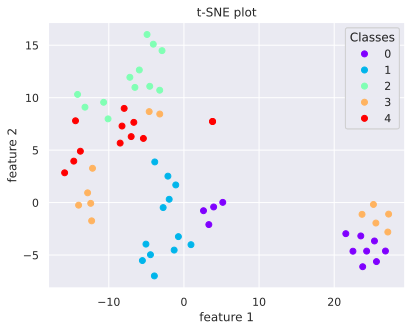

In [166]:
tsne = TSNE(n_components = 2, init = 'pca', random_state = 2024, perplexity = 12)

X_reduced = tsne.fit_transform(batch_feats.cpu().detach().numpy())

fig, ax = plt.subplots()

scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c = batch_labels.cpu().detach().numpy(), cmap = "rainbow")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('t-SNE plot')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

In [152]:
# put back
for x in interested:
    os.rename(f"/scratch/users/nus/e1329380/data/all/test/temp/{x}", f"/scratch/users/nus/e1329380/data/all/test/{x}")

In [153]:
os.rmdir("/scratch/users/nus/e1329380/data/all/test/temp/")

In [24]:
# testing on test images (LAST TIME, BUT VERY FEW IMAGES PER ITEM)
DATA_PATH = "/home/users/nus/e1329380/cs5242/project/images_test2/"
# ignore this: transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
unlabeled_data = datasets.ImageFolder(DATA_PATH, transform = transforms.Compose([transforms.CenterCrop(size=224), transforms.ToTensor()]))
# some how got duplicated images (whyyyyy?)
val_loader = data.DataLoader(unlabeled_data, batch_size=64, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
for batch_imgs, batch_labels in val_loader:
    batch_feats = model(batch_imgs.to(device))
cos_sim = F.cosine_similarity(batch_feats[:,None,:], batch_feats[None,:,:], dim=-1)
self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
cos_sim = cos_sim.masked_fill_(self_mask, -9e15)

In [45]:
dists = euclidean_distances(batch_feats.to("cpu").detach().numpy(), batch_feats.to("cpu").detach().numpy()) + np.eye(len(batch_feats))*100

In [47]:
# euclidean distance maybe better
np.argmin(dists, axis = -1)

array([1, 0, 1, 4, 3, 7, 7, 6])

In [25]:
# cosine similarity
torch.argmax(cos_sim, dim = -1)

tensor([1, 0, 6, 4, 3, 7, 7, 6], device='cuda:0')

In [26]:
unlabeled_data.imgs

[('/home/users/nus/e1329380/cs5242/project/images_test2/555（冰炫）/0205_20357.jpg',
  0),
 ('/home/users/nus/e1329380/cs5242/project/images_test2/555（冰炫）/0205_57146.jpg',
  0),
 ('/home/users/nus/e1329380/cs5242/project/images_test2/555（冰炫）/0205_88207.jpg',
  0),
 ('/home/users/nus/e1329380/cs5242/project/images_test2/RIO蓝/1103_102663.jpg',
  1),
 ('/home/users/nus/e1329380/cs5242/project/images_test2/RIO蓝/1103_65472.jpg',
  1),
 ('/home/users/nus/e1329380/cs5242/project/images_test2/Seasir丁香料酒/0716_15856.jpg',
  2),
 ('/home/users/nus/e1329380/cs5242/project/images_test2/Seasir丁香料酒/0717_42914.jpg',
  2),
 ('/home/users/nus/e1329380/cs5242/project/images_test2/Seasir丁香料酒/0717_42936.jpg',
  2)]

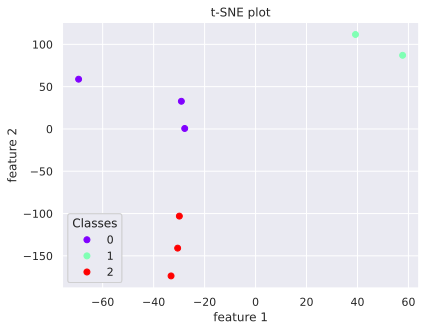

In [28]:
tsne = TSNE(n_components = 2, init = 'random', random_state = 2024, perplexity = 2)

X_reduced = tsne.fit_transform(batch_feats.cpu().detach().numpy())

fig, ax = plt.subplots()

scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c = batch_labels.cpu().detach().numpy(), cmap = "rainbow")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('t-SNE plot')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

#### Try one-shot classification using items with only 1 labelled in train

In [10]:
# test use train to predict test among others from test (items with only 1 labelled in train)
items = []
for x in os.listdir("/scratch/users/nus/e1329380/data/all/train/others_folder"):
    if x!="others":
        if len(os.listdir(f"/scratch/users/nus/e1329380/data/all/train/others_folder/{x}"))==1:
            items.append(x)
items

['长城（3号）', '兰州（吉祥16支）', '长城（132醇味）', '王冠（智者010十支）', '555（经典）', '王冠（国粹风度）']

In [59]:
with torch.no_grad():
    DATA_PATH = "/home/users/nus/e1329380/cs5242/project/images_test3/"
    # ignore this: transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    unlabeled_data = datasets.ImageFolder(DATA_PATH, transform = transforms.Compose([transforms.CenterCrop(size=224), transforms.ToTensor()]))
    val_loader = data.DataLoader(unlabeled_data, batch_size=2048, shuffle=False,
                                         drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
    for batch_imgs, batch_labels in val_loader:
        temp = batch_imgs.to(device)
        batch_feats = model(temp)
        temp.to("cpu")

In [58]:
with open("/home/users/nus/e1329380/cs5242/project/embeddings/train_1_example_embeddings.p", 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(batch_feats.to("cpu").detach().numpy(), f, pickle.HIGHEST_PROTOCOL)

In [62]:
with open("/home/users/nus/e1329380/cs5242/project/embeddings/train_1_example_path.p", 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(unlabeled_data.imgs, f, pickle.HIGHEST_PROTOCOL)

In [68]:
with torch.no_grad():
    DATA_PATH = "/home/users/nus/e1329380/cs5242/project/images_test4/"
    # ignore this: transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    unlabeled_data = datasets.ImageFolder(DATA_PATH, transform = transforms.Compose([transforms.CenterCrop(size=224), transforms.ToTensor()]))
    val_loader = data.DataLoader(unlabeled_data, batch_size=2048, shuffle=False,
                                         drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
    for batch_imgs, batch_labels in val_loader:
        temp = batch_imgs.to(device)
        batch_feats = model(temp)
        temp.to("cpu")

In [71]:
with open("/home/users/nus/e1329380/cs5242/project/embeddings/test_1_example_embeddings.p", 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(batch_feats.to("cpu").detach().numpy(), f, pickle.HIGHEST_PROTOCOL)

In [72]:
with open("/home/users/nus/e1329380/cs5242/project/embeddings/test_1_example_path.p", 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(unlabeled_data.imgs, f, pickle.HIGHEST_PROTOCOL)

In [24]:
# test use train to predict test among others from test
train_1_example_embeddings = pickle.load(open("/home/users/nus/e1329380/cs5242/project/embeddings/train_1_example_embeddings.p", "rb"))
train_1_example_path = pickle.load(open("/home/users/nus/e1329380/cs5242/project/embeddings/train_1_example_path.p", "rb"))
test_1_example_embeddings = pickle.load(open("/home/users/nus/e1329380/cs5242/project/embeddings/test_1_example_embeddings.p", "rb"))
test_1_example_path = pickle.load(open("/home/users/nus/e1329380/cs5242/project/embeddings/test_1_example_path.p", "rb"))
test_others_embeddings = pickle.load(open("/home/users/nus/e1329380/cs5242/project/embeddings/test_others_embeddings.p", "rb"))
test_others_path = pickle.load(open("/home/users/nus/e1329380/cs5242/project/embeddings/test_others_path.p", "rb"))

In [19]:
# 555（经典） not found in test and 长城（132醇味）looks very different in train and test
dists = euclidean_distances(train_1_example_embeddings, np.concatenate((test_1_example_embeddings, test_others_embeddings), axis = 0))
for i, x in enumerate(np.argmin(dists, axis = -1)):
    print("="*80)
    print(train_1_example_path[i])
    print((test_1_example_path + test_others_path)[x])

('/home/users/nus/e1329380/cs5242/project/images_test3/555（经典）/截屏2019-12-10下午5.13.43.png', 0)
('/scratch/users/nus/e1329380/data/all/test/others_folder/others/0506_15924.jpg', 0)
('/home/users/nus/e1329380/cs5242/project/images_test3/兰州（吉祥16支）/1201_1258.jpg', 1)
('/scratch/users/nus/e1329380/data/all/test/others_folder/others/0506_20333.jpg', 0)
('/home/users/nus/e1329380/cs5242/project/images_test3/王冠（国粹风度）/截屏2019-12-19下午6.55.392.png', 2)
('/home/users/nus/e1329380/cs5242/project/images_test4/王冠（国粹风度）/截屏2019-12-19下午6.55.39.png', 1)
('/home/users/nus/e1329380/cs5242/project/images_test3/王冠（智者010十支）/截屏2019-12-19下午7.40.41.png', 3)
('/home/users/nus/e1329380/cs5242/project/images_test4/王冠（智者010十支）/截屏2019-12-19下午7.40.412.png', 2)
('/home/users/nus/e1329380/cs5242/project/images_test3/长城（132醇味）/截屏2019-12-19下午7.47.41.png', 4)
('/scratch/users/nus/e1329380/data/all/test/others_folder/others/1201_18702.jpg', 0)
('/home/users/nus/e1329380/cs5242/project/images_test3/长城（3号）/截屏2019-12-19下午7.50.04

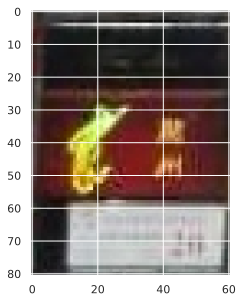

In [17]:
IMG_PATH = '/home/users/nus/e1329380/cs5242/project/images_test3/兰州（吉祥16支）/1201_1258.jpg'
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

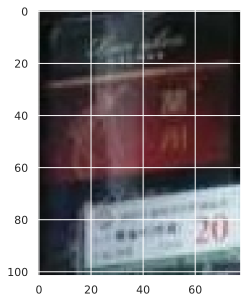

In [20]:
IMG_PATH = '/home/users/nus/e1329380/cs5242/project/images_test4/兰州（吉祥16支）/1201_13790.jpg'
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

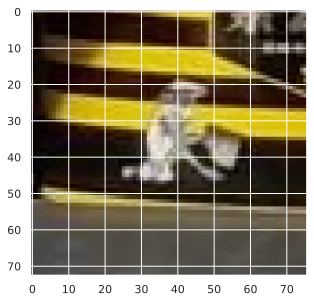

In [18]:
IMG_PATH = '/scratch/users/nus/e1329380/data/all/test/others_folder/others/0506_20333.jpg'
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

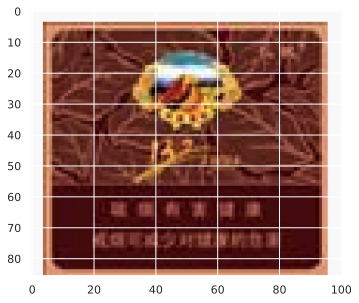

In [22]:
IMG_PATH = '/home/users/nus/e1329380/cs5242/project/images_test3/长城（132醇味）/截屏2019-12-19下午7.47.41.png'
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

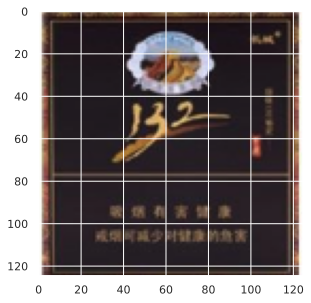

In [45]:
IMG_PATH = '/home/users/nus/e1329380/cs5242/project/images_test4/长城（132醇味）/截屏2019-12-19下午7.47.47.png'
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )

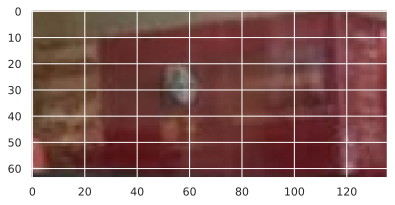

In [23]:
IMG_PATH = '/scratch/users/nus/e1329380/data/all/test/others_folder/others/1201_18702.jpg'
test = read_image(IMG_PATH)
plt.imshow(  test.permute(1, 2, 0)  )